In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_auc_score, roc_curve, precision_recall_fscore_support
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#importar datos
train = pd.read_csv('train.csv')
test = pd.read_csv('test_kaggle.csv')
train.head()

,title_index,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,budget,usa_gross_income,worlwide_gross_income,popularity
0,20003,Il terrorista,Il terrorista,1963,1965-05-27,Drama,95,"Italy, France","Italian, German",Gianfranco De Bosio,"Gianfranco De Bosio, Luigi Squarzina",22 Dicembre,"Gian Maria Volontè, Philippe Leroy, Giulio Bos...",War drama inspired by real life events of the ...,NaN,NaN,NaN,popular
1,20004,Il secondo risveglio di Christa Klages,Das zweite Erwachen der Christa Klages,1978,1978-04-14,Drama,92,West Germany,German,Margarethe von Trotta,"Margarethe von Trotta, Luisa Francia",Bioskop Film,"Tina Engel, Silvia Reize, Katharina Thalbach, ...",Three people rob a bank to help a day care cen...,NaN,NaN,NaN,popular
2,20005,L'affascinante straniero,Love from a Stranger,1947,1947-11-15,"Drama, Mystery, Romance",81,USA,English,Richard Whorf,"Philip MacDonald, Frank Vosper",Bryan Foy Productions,"John Hodiak, Sylvia Sidney, Ann Richards, John...",A newly married woman begins to suspect that h...,NaN,NaN,NaN,unpopular
3,20006,Rainy Dog,Gokudô kuroshakai,1997,1997-06-28,"Crime, Drama",95,Japan,"Japanese, Mandarin, Min Nan",Takashi Miike,Seigo Inoue,Daiei,"Shô Aikawa, Li Wei Chang, Shih Chang, Xianmei ...",A Japanese assassin stranded in Taiwan must ta...,NaN,NaN,NaN,popular
4,20007,Un eroe borghese,Un eroe borghese,1995,1995-03-03,"Crime, Drama, Thriller",93,"Italy, France",Italian,Michele Placido,"Graziano Diana, Angelo Pasquini",Corsan,"Fabrizio Bentivoglio, Michele Placido, Omero A...","An intriguing look at a sinister web of power,...",NaN,NaN,NaN,popular


In [3]:
train.describe()

,title_index,year,duration
count,65846.000000,65846.000000,65846.000000
mean,52929.072913,1993.467940,100.271679
std,19010.067979,24.252124,22.442404
min,20003.000000,1894.000000,41.000000
25%,36466.250000,1979.000000,88.000000
50%,52929.500000,2003.000000,96.000000
75%,69391.750000,2013.000000,108.000000
max,85854.000000,2020.000000,808.000000


In [4]:
train.isnull().sum()

title_index                  0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                     52
language                   676
director                    63
writer                    1216
production_company        3402
actors                      47
description               1590
budget                   47749
usa_gross_income         54100
worlwide_gross_income    42143
popularity                   0
dtype: int64

C:\Users\vpn\AppData\Local\Temp\ipykernel_31564\3462896523.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train, x='popularity', y='duration', palette='Set2')


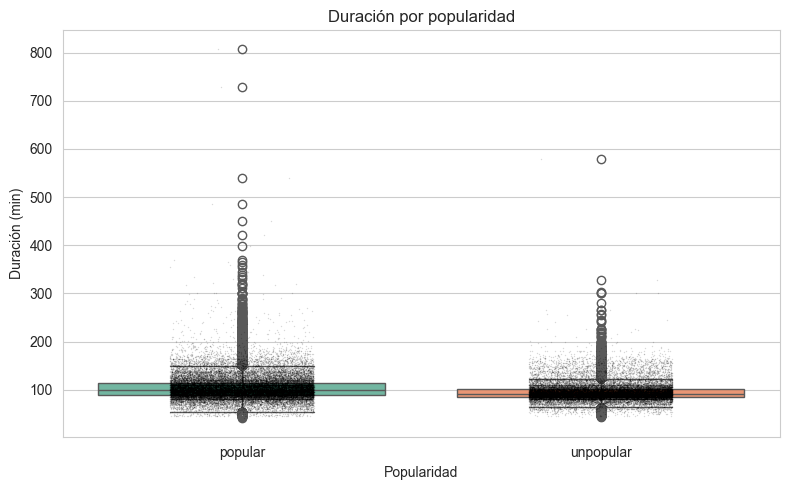

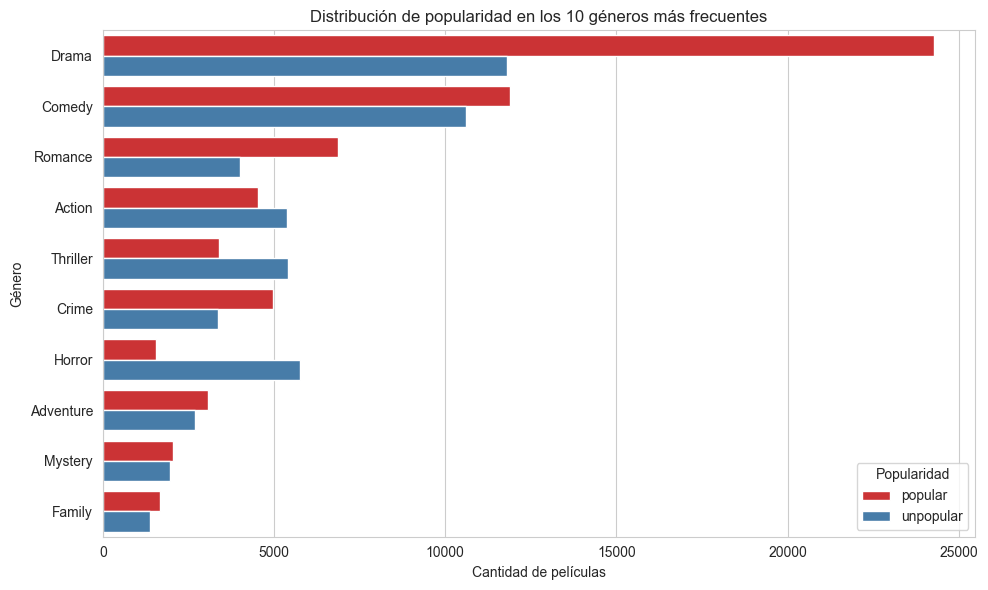

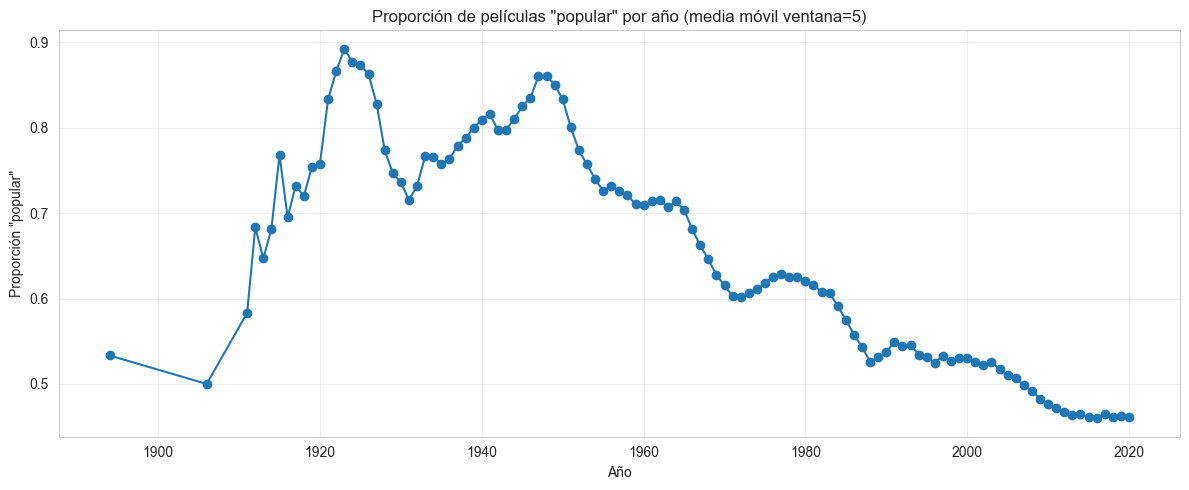

In [5]:
# Plots: popularidad vs duración, popularidad vs genre, popularidad vs year
sns.set_style("whitegrid")

# 1) Popularidad según duración (boxplot + strip)
plt.figure(figsize=(8, 5))
sns.boxplot(data=train, x='popularity', y='duration', palette='Set2')
sns.stripplot(data=train, x='popularity', y='duration', color='k', alpha=0.15, jitter=0.2, size=1)
plt.title('Duración por popularidad')
plt.xlabel('Popularidad')
plt.ylabel('Duración (min)')
plt.tight_layout()
plt.show()

# 2) Popularidad según genre (explosion de géneros y countplot de los top 10)
df_genres = train[['genre', 'popularity']].dropna(subset=['genre'])
df_genres = df_genres.assign(genre=df_genres['genre'].str.split(',')).explode('genre')
df_genres['genre'] = df_genres['genre'].str.strip().replace('', np.nan).dropna()

top_genres = df_genres['genre'].value_counts().nlargest(10).index
df_top = df_genres[df_genres['genre'].isin(top_genres)]

plt.figure(figsize=(10, 6))
sns.countplot(data=df_top, y='genre', hue='popularity', order=top_genres, palette='Set1')
plt.title('Distribución de popularidad en los 10 géneros más frecuentes')
plt.xlabel('Cantidad de películas')
plt.ylabel('Género')
plt.legend(title='Popularidad')
plt.tight_layout()
plt.show()

# 3) Popularidad según year (proporción de "popular" por año, suavizado)
df_year = train[['year', 'popularity']].dropna(subset=['year', 'popularity']).copy()
df_year['year'] = pd.to_numeric(df_year['year'], errors='coerce')
df_year = df_year.dropna(subset=['year'])
df_year['year'] = df_year['year'].astype(int)

group = df_year.groupby(['year', 'popularity']).size().unstack(fill_value=0)
group = group.sort_index()

# calcular proporción de "popular" y suavizar con rolling window
if 'popular' in group.columns:
    prop_popular = group['popular'] / group.sum(axis=1)
    prop_popular_smoothed = prop_popular.rolling(window=5, min_periods=1, center=True).mean()

    plt.figure(figsize=(12, 5))
    plt.plot(prop_popular_smoothed.index, prop_popular_smoothed.values, marker='o', linestyle='-')
    plt.title('Proporción de películas "popular" por año (media móvil ventana=5)')
    plt.xlabel('Año')
    plt.ylabel('Proporción "popular"')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('No se encontró la categoría "popular" en la columna "popularity".')

In [6]:
#Seleccionar columnas
target_col = 'popularity'
X = train.drop(columns=[target_col])
y = train[target_col].copy()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()


In [7]:
#Preprocesamiento de datos
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)

In [ ]:
#Division entrenamiento y validacion
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train:", X_train.shape, "Val:", X_val.shape)

pipe = Pipeline(steps=[
    ('preproc', preprocessor),
    ('svc', SVC(kernel='rbf', probability=True, random_state=42))
])

pipe.fit(X_train, y_train)

Train: (52676, 17) Val: (13170, 17)


,steps,"[('preproc', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
